Selected Features: Index(['VerticalSize', 'PeakVerticalVelocity', 'Slant', 'AbsoluteyJerk',
       'NormalizedyJerk', 'AverageNormalizedyJerkPerTrial', 'AbsoluteJerk',
       'NormalizedJerk', 'AverageNormalizedJerkPerTrial',
       'AveragePenPressure'],
      dtype='object')
Epoch 1/50


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [15 16 17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - accuracy: 0.7396 - loss: 0.6566 - val_accuracy: 0.8824 - val_loss: 0.5879
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7188 - loss: 0.6318 - val_accuracy: 0.8824 - val_loss: 0.5691
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6979 - loss: 0.6161 - val_accuracy: 0.8824 - val_loss: 0.5526
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7292 - loss: 0.6088 - val_accuracy: 0.8824 - val_loss: 0.5370
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7188 - loss: 0.5973 - val_accuracy: 0.8824 - val_loss: 0.5239
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7292 - loss: 0.5795 - val_accuracy: 0.8824 - val_loss: 0.5123
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7500 - loss: 0.5625 - val_accuracy: 0.8824 - val_loss: 0.5019
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7812 - loss: 0.5246 - val_accuracy: 0.8824 - val_loss: 0.4911
Epoch 

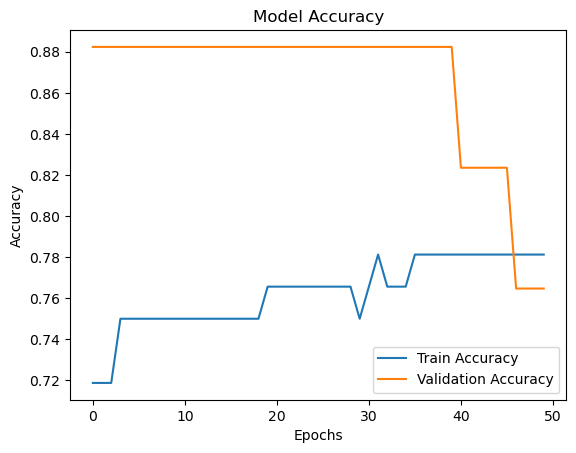

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

# Step 1: Load the CSV data
data = pd.read_csv("data.csv")  # Replace 'data.csv' with your file name

# Step 2: Preprocess the data
# Separate features and target labelcC
X = data.drop(columns=["Class", "UID", "Trial", "TrialSeq"])  # Exclude non-feature columns
y = data["Class"]

# Encode the target label (e.g., "dys" = 1, "td" = 0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 3: Select top 10 features using ANOVA F-test
feature_selector = SelectKBest(score_func=f_classif, k=10)
X_selected = feature_selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[feature_selector.get_support()]
print("Selected Features:", selected_features)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Step 5: Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Build the DT-GCN model (Dynamic Temporal Graph Convolutional Network)
class DTGCNModel(tf.keras.Model):
    def __init__(self):
        super(DTGCNModel, self).__init__()
        self.hidden1 = layers.Dense(64, activation='relu')
        self.hidden2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        return self.output_layer(x)

# Initialize the model
model = DTGCNModel()

# Step 7: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

# Step 9: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Step 10: Test the model with predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Visualize training results
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
model.save("dysgraphia_model.keras")



In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from flask import Flask, render_template, request
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

# Custom model class
class DTGCNModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super(DTGCNModel, self).__init__(**kwargs)
        self.hidden1 = layers.Dense(64, activation='relu')
        self.hidden2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        return self.output_layer(x)

    def get_config(self):
        config = super(DTGCNModel, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        base_config = config.get('config', {})
        model = super(DTGCNModel, cls).from_config(config)
        model.__dict__.update(base_config)
        return model

# Initialize Flask app
app = Flask(__name__)

# Load the trained model with the custom model class
model = load_model("dysgraphia_model.keras", custom_objects={"DTGCNModel": DTGCNModel})

# Initialize the scaler (assuming you used StandardScaler during training)
scaler = StandardScaler()

# Route for home page
@app.route("/")
def home():
    return """
    <h1>Predict Dysgraphia</h1>
    <form method="POST" action="/predict">
        VerticalSize: <input type="text" name="VerticalSize"><br>
        PeakVerticalVelocity: <input type="text" name="PeakVerticalVelocity"><br>
        Slant: <input type="text" name="Slant"><br>
        AbsoluteyJerk: <input type="text" name="AbsoluteyJerk"><br>
        NormalizedyJerk: <input type="text" name="NormalizedyJerk"><br>
        AverageNormalizedyJerkPerTrial: <input type="text" name="AverageNormalizedyJerkPerTrial"><br>
        AbsoluteJerk: <input type="text" name="AbsoluteJerk"><br>
        NormalizedJerk: <input type="text" name="NormalizedJerk"><br>
        AverageNormalizedJerkPerTrial: <input type="text" name="AverageNormalizedJerkPerTrial"><br>
        AveragePenPressure: <input type="text" name="AveragePenPressure"><br>
        <button type="submit">Predict</button>
    </form>
    """

@app.route("/predict", methods=["POST"])
def predict():
    try:
        features = np.array([[
            float(request.form["VerticalSize"]),
            float(request.form["PeakVerticalVelocity"]),
            float(request.form["Slant"]),
            float(request.form["AbsoluteyJerk"]),
            float(request.form["NormalizedyJerk"]),
            float(request.form["AverageNormalizedyJerkPerTrial"]),
            float(request.form["AbsoluteJerk"]),
            float(request.form["NormalizedJerk"]),
            float(request.form["AverageNormalizedJerkPerTrial"]),
            float(request.form["AveragePenPressure"])
        ]])

        # Standardize the input features using the scaler
        features_scaled = scaler.fit_transform(features)

        # Make predictions with the model
        prediction = model.predict(features_scaled)
        
        # Convert the prediction to a human-readable result
        result = "Dysgraphic" if prediction > 0.5 else "Non-Dysgraphic"
        return f"Prediction: {result}"
    except Exception as e:
        return f"Error occurred: {str(e)}"

# Run the Flask app only if in Jupyter
from werkzeug.serving import run_simple

def run_app():
    run_simple("localhost", 5000, app)

run_app()


 * Running on http://localhost:5000
Press CTRL+C to quit
127.0.0.1 - - [21/Jan/2025 22:08:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2025 22:08:41] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [21/Jan/2025 22:09:55] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


127.0.0.1 - - [21/Jan/2025 22:10:44] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


127.0.0.1 - - [21/Jan/2025 22:11:52] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


127.0.0.1 - - [21/Jan/2025 22:12:09] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


127.0.0.1 - - [21/Jan/2025 22:13:57] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2025 22:14:39] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2025 22:14:40] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


127.0.0.1 - - [21/Jan/2025 22:15:06] "POST /predict HTTP/1.1" 200 -
